In [222]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import visualkeras as vk

import keras_tuner as kt
from keras_tuner import HyperParameters as hp

import os

folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)



# Custom Functions

In [223]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()



In [224]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [225]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)


In [226]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



# Preprocessing

In [227]:
# Checking the contents of farm_insects
data_dir = 'C:\\Users\\Ashraf\\Desktop\\New folder (2)\\farm_insects'
data_dir 

'C:\\Users\\Ashraf\\Desktop\\New folder (2)\\farm_insects'

In [228]:
# Gettting the list of folders from data dir
subfolders = os.listdir(data_dir)
subfolders

['Africanized Honey Bees (Killer Bees)',
 'Aphids',
 'Armyworms',
 'Brown Marmorated Stink Bugs',
 'Cabbage Loopers',
 'Citrus Canker',
 'Colorado Potato Beetles',
 'Corn Borers',
 'Corn Earworms',
 'Fall Armyworms',
 'Fruit Flies',
 'Spider Mites',
 'Thrips',
 'Tomato Hornworms',
 'Western Corn Rootworms']

In [229]:
# Getting list of img file paths (no folders)
img_files = glob.glob(data_dir + "\\**\\*.jpg", recursive=False)
#img_files += glob.glob(data_dir + "\\**\\*.jpeg", recursive=False)
#img_files += glob.glob(data_dir + "\\**\\*.png", recursive=False)
len(img_files)

1464

In [230]:
# Take a look at the first 5 filepaths
img_files[0:16]

img_lod =  load_img(img_files[0])
img_data = img_to_array(img_lod)
img_data.shape


(650, 1160, 3)

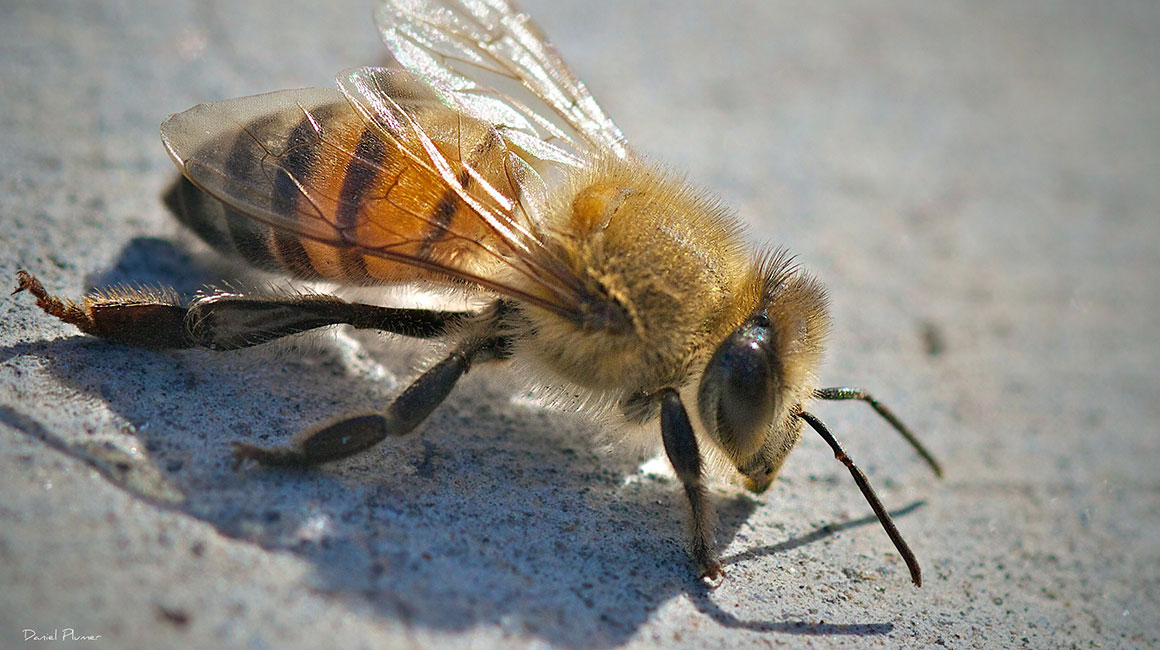

In [231]:
array_to_img(img_data)

# Create a Tensorflow Image Dataset

In [232]:
label_model  =  'categorical'
image_size  = (128,128)
random_state= 123 
batch_size=32

In [233]:
ds = tf.keras.utils.image_dataset_from_directory(directory=data_dir,
                                                 label_mode=label_model,
                                                 image_size=image_size,
                                                 batch_size=batch_size,shuffle=True
                                
)
ds
ds_size = len(ds)
# Determine number of batches in dataset
ds_size

Found 1591 files belonging to 15 classes.


50

In [234]:
exampel_img_batch ,exampel_batch_y= ds.take(1).get_single_element()
exampel_img_batch.shape

TensorShape([32, 128, 128, 3])

In [235]:
exampel_batch_y[:5]

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [236]:
calss_name = ds.class_names
# Saving # of classes for reuse
num_classes = len(calss_name)
num_classes
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes),calss_name))
class_dict


{0: 'Africanized Honey Bees (Killer Bees)',
 1: 'Aphids',
 2: 'Armyworms',
 3: 'Brown Marmorated Stink Bugs',
 4: 'Cabbage Loopers',
 5: 'Citrus Canker',
 6: 'Colorado Potato Beetles',
 7: 'Corn Borers',
 8: 'Corn Earworms',
 9: 'Fall Armyworms',
 10: 'Fruit Flies',
 11: 'Spider Mites',
 12: 'Thrips',
 13: 'Tomato Hornworms',
 14: 'Western Corn Rootworms'}

In [237]:
input_shape= exampel_img_batch[0].shape
input_shape= [*input_sahpe]     # We will unpack the shape using *
input_shape

[128, 128, 3]

# Train, Validation, and Test Split

In [238]:
split_train = 0.7 
split_val = 0.2 
split_test = 0.1
n_train_batch = int(ds_size*split_train)
n_val_batch= int(ds_size*split_val)
print(f"Use {n_train_batch} batches as training data")
print(f"Use {n_val_batch} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batch+n_val_batch)} batches will be used as test data.")

Use 35 batches as training data
Use 10 batches as validation data
The remaining 5 batches will be used as test data.


In [239]:
# Now we will divide up the batches using TensorFlow's .take() and .skip(). 
train_ds = ds.take(n_train_batch)
len(train_ds)

35

In [240]:
# Skipover the training batches
val_ds = ds.skip(n_train_batch)
# Take the correct number of validation batches
val_ds = ds.take(n_val_batch)
# Confirm the length of the validation set
len(val_ds)

10

In [241]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batch+n_val_batch)
# Confirm the length of the testing data
len(test_ds)

5

# Optimize the Dataset

In [242]:
buffer_size= len(train_ds)

In [243]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE



In [244]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building the Model

In [245]:
def build_model():
    model = models.Sequential()
    scaleing_model = layers.Rescaling(1/255, input_shape=input_shape)
    # Convolutional layer
    model.add(layers.Conv2D(filters=16 , kernel_size=3 ,input_shape=input_shape, padding='same', ))
     # pooling layers                       
    model.add(layers.MaxPool2D(pool_size=2))
    # Convolutional layer
    model.add(layers.Conv2D(filters=32,kernel_size=3,padding='same', input_shape=input_shape))
     # pooling layers  
    model.add(layers.MaxPool2D(pool_size=2))
     #Flatten layars                       
    model.add(layers.Flatten())
    model.add(layers.Dense(15,activation="softmax"))
      
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.summary()
    return model
    

In [246]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 15)                4

In [247]:
epochs= 10 
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, 
)

Epoch 1/10
35/35 [==============================] - 35s 418ms/step - loss: 326.9784 - accuracy: 0.1009 - val_loss: 93.1244 - val_accuracy: 0.3187
Epoch 2/10
35/35 [==============================] - 9s 244ms/step - loss: 50.3359 - accuracy: 0.3991 - val_loss: 27.4956 - val_accuracy: 0.5656
Epoch 3/10
35/35 [==============================] - 9s 252ms/step - loss: 19.3158 - accuracy: 0.6482 - val_loss: 15.9936 - val_accuracy: 0.6094
Epoch 4/10
35/35 [==============================] - 9s 251ms/step - loss: 13.2353 - accuracy: 0.6946 - val_loss: 4.1975 - val_accuracy: 0.8500
Epoch 5/10
35/35 [==============================] - 9s 271ms/step - loss: 5.2201 - accuracy: 0.8429 - val_loss: 3.3156 - val_accuracy: 0.9062
Epoch 6/10
35/35 [==============================] - 11s 321ms/step - loss: 2.4524 - accuracy: 0.9152 - val_loss: 1.8737 - val_accuracy: 0.9250
Epoch 7/10
35/35 [==============================] - 9s 257ms/step - loss: 1.6034 - accuracy: 0.9348 - val_loss: 2.2324 - val_accuracy: 0.9

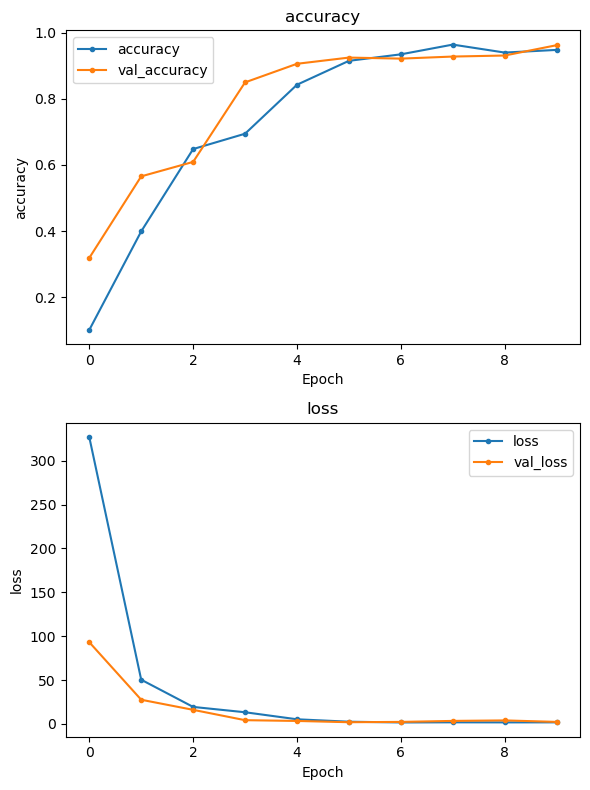

In [248]:
plot_history(history)

In [249]:
y_test , y_prad= get_true_pred_labels(model,ds)
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [250]:
y_prad_trsndformer =  convert_y_to_sklearn_classes(y_prad)
y_prad_trsndformer[:5]

array([12,  7,  7,  7,  9], dtype=int64)

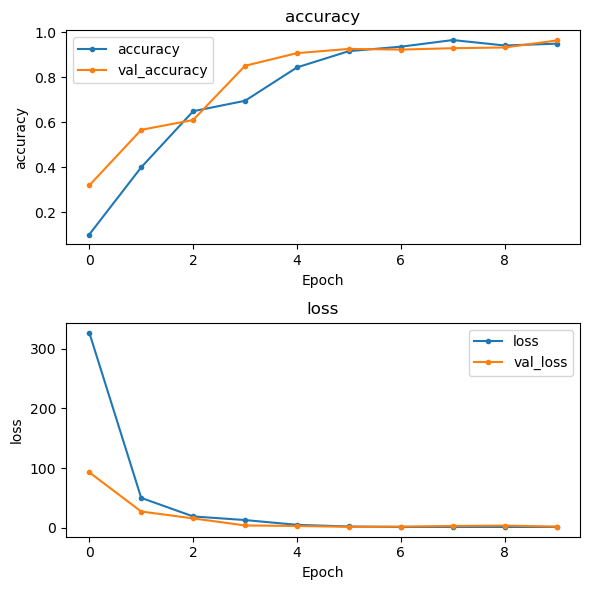


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.60      0.56        15
           1       0.25      0.50      0.33         6
           2       0.11      0.14      0.12         7
           3       0.33      0.70      0.45        10
           4       0.50      0.38      0.43         8
           5       0.42      0.45      0.43        11
           6       0.50      0.43      0.46         7
           7       0.40      0.29      0.33         7
           8       0.40      0.31      0.35        13
           9       0.21      0.30      0.25        10
          10       0.71      0.42      0.53        12
          11       0.83      0.33      0.48        15
          12       0.62      0.62      0.62         8
          13       0.62      0.57      0.

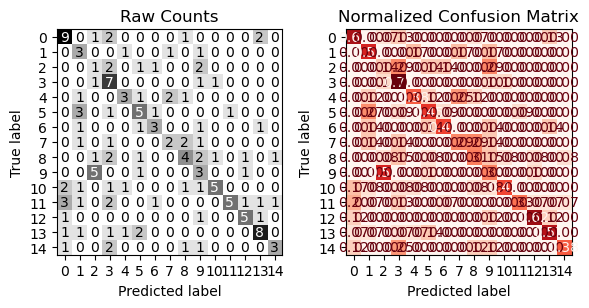


- Evaluating Test Data:
5/5 [==============================] - 0s 66ms/step - loss: 30.5569 - accuracy: 0.4371
{'loss': 30.55691146850586, 'accuracy': 0.4370861053466797}


In [251]:
# Testing with the CNN + Dataset
evaluate_classification_network(model, X_test=test_ds, history=history);



# tuning 

In [252]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



In [253]:
model1=build_model()
vk.layered_view(model1, legend=True)

history = model1.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 15)               

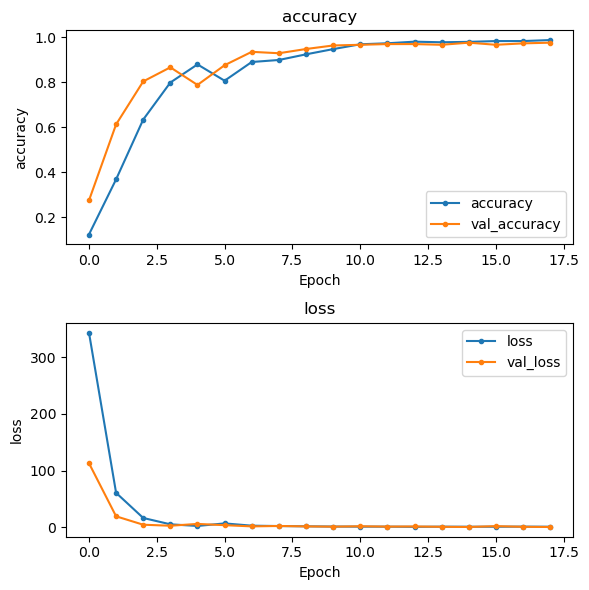


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        61
           2       0.92      0.88      0.90        65
           3       1.00      1.00      1.00        84
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        77
           8       1.00      1.00      1.00        79
           9       0.90      0.93      0.91        74
          10       1.00      1.00      1.00        69
          11       1.00      1.00      1.00        88
          12       1.00      1.00      1.00        82
          13       1.00      1.00    

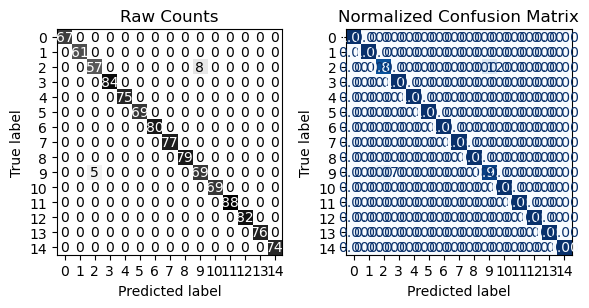


- Evaluating Training Data:
35/35 [==============================] - 3s 76ms/step - loss: 0.5447 - accuracy: 0.9884
{'loss': 0.5446805953979492, 'accuracy': 0.9883928298950195}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.67      0.67      0.67         6
           2       0.20      0.14      0.17         7
           3       0.50      0.60      0.55        10
           4       0.30      0.38      0.33         8
           5       0.50      0.36      0.42        11
           6       0.26      0.71      0.38         7
           7       0.50      0.43      0.46         7
           8       0.36      0.31      0.33        13
           9       0.30      0.30      0.30        10
          10       0.60      0.50      0.55       

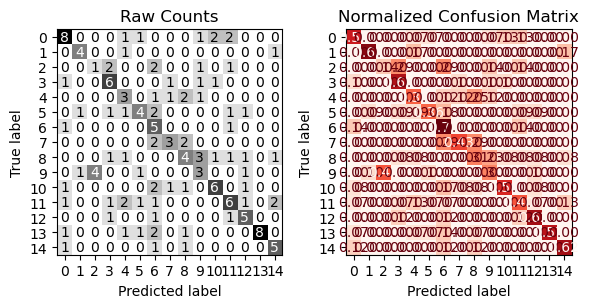


- Evaluating Test Data:
5/5 [==============================] - 0s 69ms/step - loss: 22.3949 - accuracy: 0.4702
{'loss': 22.394886016845703, 'accuracy': 0.4701986610889435}


In [254]:
evaluate_classification_network(model1, X_train=train_ds ,X_test=test_ds,history=history )

# Adding Hidden Dense Layer

In [255]:
def build_model_dense():
    model = models.Sequential(name='Model2')
    model.add(layers.Rescaling(1. / 255, input_shape=input_shape))
    # Conv2d/MaxPooling #1
    model.add(layers.Conv2D(16, kernel_size=3, padding='same'))
    model.add(layers.MaxPooling2D(2, strides=1))
    # Conv2d/MaxPooling #2
    model.add(layers.Conv2D(32, kernel_size=3,padding='same'))
    model.add(layers.MaxPooling2D(2, strides=1))
    model.add(layers.Flatten())
    ## NEW Hidden Dense layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dense(len(calss_name), activation="softmax"))
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            "accuracy"]
    )
    return model



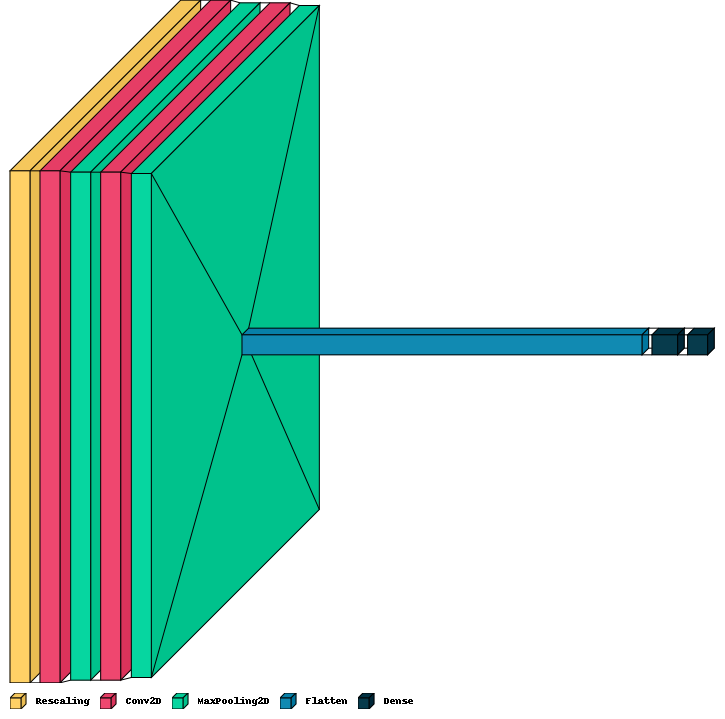

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 127, 127, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 508032)            0    

In [256]:
model2 = build_model_dense()
display(vk.layered_view(model2, legend=True))
model2.summary()

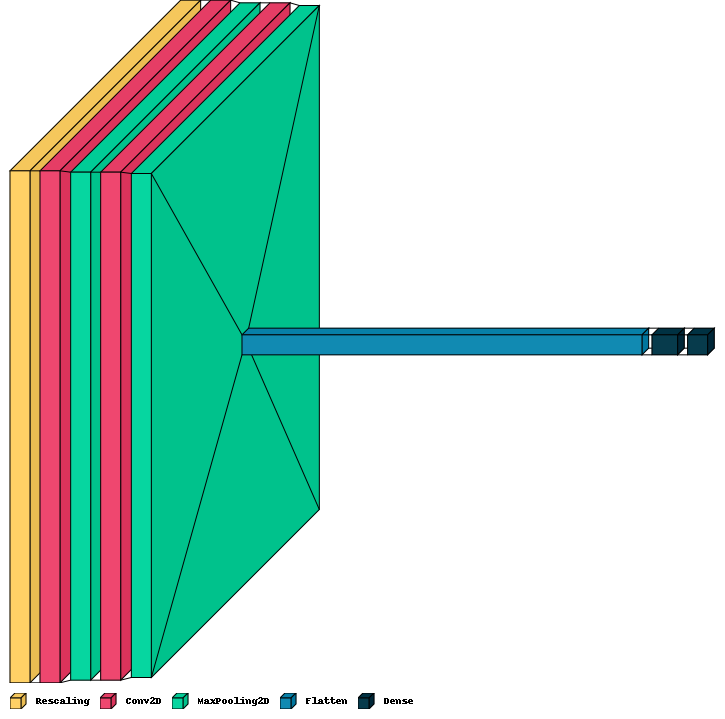

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 127, 127, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 508032)            0    

In [257]:
model2 = build_model_dense()
display(vk.layered_view(model2, legend=True))
model2.summary()
# fit the neural network
history = model2.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks()
)

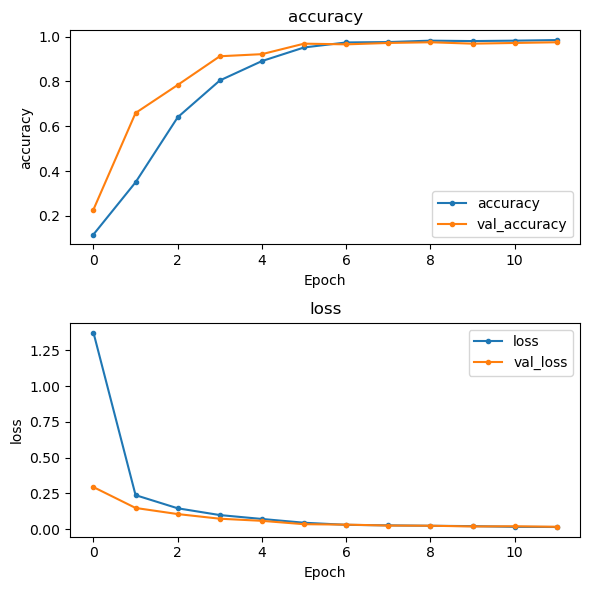


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        61
           2       0.89      0.91      0.90        65
           3       1.00      1.00      1.00        84
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        77
           8       1.00      1.00      1.00        79
           9       0.92      0.91      0.91        74
          10       1.00      1.00      1.00        69
          11       1.00      1.00      1.00        88
          12       1.00      1.00      1.00        82
          13       1.00      1.00    

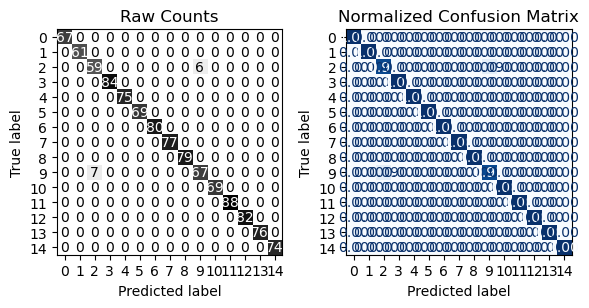


- Evaluating Training Data:
35/35 [==============================] - 12s 356ms/step - loss: 0.0104 - accuracy: 0.9884
{'loss': 0.010402538813650608, 'accuracy': 0.9883928298950195}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.33      0.48        15
           1       0.60      0.50      0.55         6
           2       0.05      0.14      0.08         7
           3       0.43      0.60      0.50        10
           4       0.19      0.38      0.25         8
           5       1.00      0.45      0.62        11
           6       0.50      0.43      0.46         7
           7       0.20      0.29      0.24         7
           8       0.38      0.46      0.41        13
           9       0.36      0.40      0.38        10
          10       0.67      0.50      0.57   

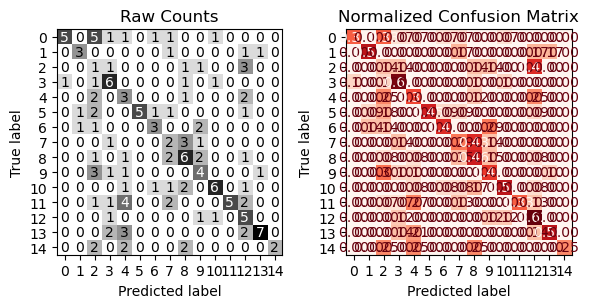


- Evaluating Test Data:
5/5 [==============================] - 1s 264ms/step - loss: 0.2985 - accuracy: 0.4172
{'loss': 0.29848039150238037, 'accuracy': 0.41721853613853455}


In [258]:
evaluate_classification_network(model2, X_train=train_ds ,X_test=test_ds,history=history )

# Tuning CNNs

In [259]:
def build_model2(hp):
    
    model = models.Sequential(name='TunedModel')
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=hp.Int(name='filters_1', 
                           min_value=32, 
                           max_value=64,
                           step=16),  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'))
    
    # Pooling layer
    pool_padding = 'same'
    pool_strides = 2
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=hp.Int(name='filters_2', 
                           min_value=32, 
                           max_value=64,
                           step=32),  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same')) 

    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling




    # if hp.Boolean('batch_normalization'):
    #     model.add(layers.BatchNormalization())
        
    
    # Flattening layer
    model.add(layers.Flatten())

    # Tune n_dense layers
    n_layers = hp.Int('n_hidden_dense_layers', 
                          min_value=1,
                          max_value=3)
    n_units = hp.Float('n_units_dense',min_value=128,max_value=1024,step=128,)
    dropout_rate = hp.Float("drop_rate",min_value=0.0,
                                         max_value=0.5, step=0.1)
    for n in range(n_layers):
        model.add(layers.Dense(n_units, activation='relu'))       
        # Add dropout
        model.add(layers.Dropout(dropout_rate))
    
        
        
    # Output layer
    model.add(
        layers.Dense(len(calss_name), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    # ## Tuning for Optimizer (classes)
    # chosen_optimizer = hp.Choice('optimizer',['adam','nadam','rmsprop'])
    # if chosen_optimizer=='adam':
    #     optimizer = tf.keras.optimizers.legacy.Adam()
    # elif chosen_optimizer=='nadam':
    #     optimizer =tf.keras.optimizers.legacy.Nadam()
    # elif chosen_optimizer=='rmsprop':
    #     optimizer = tf.keras.optimizers.legacy.RMSprop()

    

    ## Compile model   
    lr = hp.Float('learning_rate',min_value=.0001, max_value=10, step=10, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy',])
    
    model.summary()
    return model

In [260]:
def get_callbacks( ):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_accuracy')
    
    return [early_stopping]

In [261]:
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
import os

# Creating the directory for kerastuner's results
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [262]:
#hyperband allows for callbacks
tuner_hb = kt.Hyperband(build_model2, objective='val_accuracy',
                        max_epochs=25, overwrite=True, directory=folder, 
                project_name='tuning-cnn1',)
tuner_hb.search_space_summary()

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0

In [263]:
tuner_hb.search(train_ds,validation_data=val_ds, epochs=20)#, callbacks=get_callbacks())
tuner_hb.results_summary()

Trial 30 Complete [00h 11m 06s]
val_accuracy: 0.9781249761581421

Best val_accuracy So Far: 0.987500011920929
Total elapsed time: 02h 08m 03s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in KerasTuner/tuning-cnn1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0027 summary
Hyperparameters:
filters_1: 32
filters_2: 64
n_hidden_dense_layers: 3
n_units_dense: 768.0
drop_rate: 0.0
learning_rate: 0.001
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.987500011920929

Trial 0016 summary
Hyperparameters:
filters_1: 32
filters_2: 32
n_hidden_dense_layers: 1
n_units_dense: 896.0
drop_rate: 0.2
learning_rate: 0.0001
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.9781249761581421

Trial 0024 summary
Hyperparameters:
filters_1: 64
filters_2: 64
n_hidden_dense_layers: 1
n_units_dense: 512.0
drop_rate: 0.2
learning_rate: 0.001
tuner/epochs: 25
tuner/initial_epoch: 9
t

In [264]:
best_hps = tuner_hb.get_best_hyperparameters()[0]
print(best_hps.values)

{'filters_1': 32, 'filters_2': 64, 'n_hidden_dense_layers': 3, 'n_units_dense': 768.0, 'drop_rate': 0.0, 'learning_rate': 0.001, 'tuner/epochs': 25, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [265]:
best_model = tuner_hb.get_best_models()[0]
best_model.summary()

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0

In [266]:
af.evaluate_classification_network(best_model,X_train=train_ds, X_test=test_ds,
                                   figsize=(6,8), values_format='.1f'
);

NameError: name 'af' is not defined